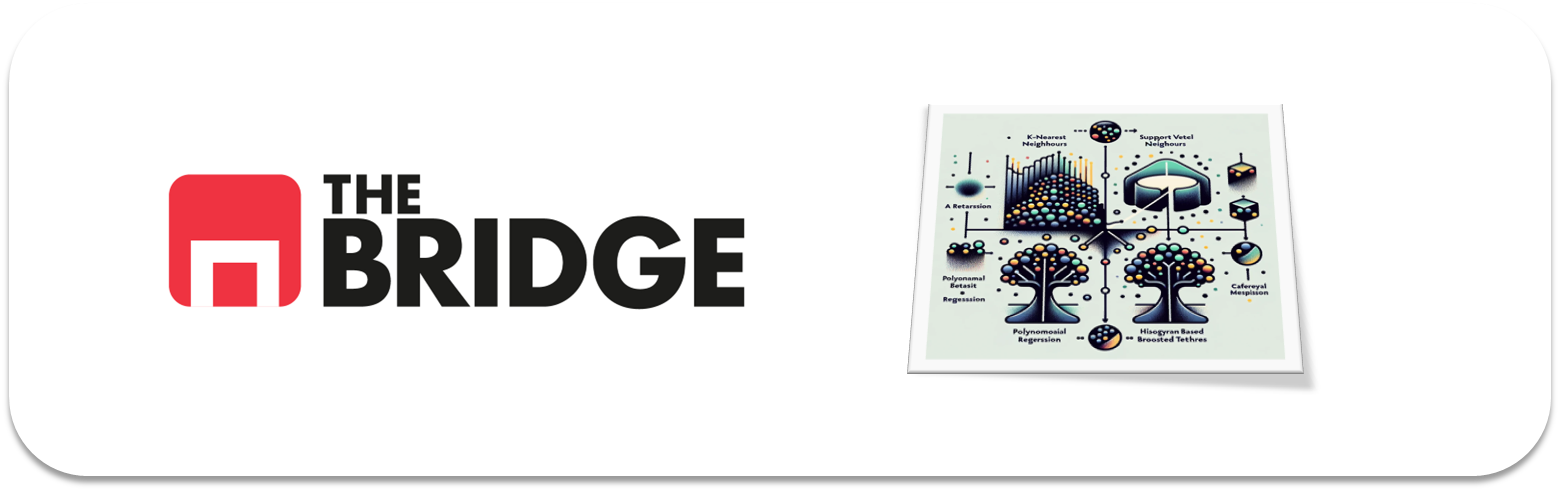

# Análisis de Errores

Una parte que no debemos descuidar es el análisis de errores y más si conocemos el impacto de estos en nuestro problema de negocio. A continuación vamos a ver de una forma introductoria como acometer esta tarea, planteándola para problemas de clasificación primero y de regresión después (ya que las métricas y los objetivos son diferentes y por tanto la visualización de los errores también)

Para trabajar ambas situaciones usaremos el dataset `diamonds` que nos permite plantear problemas de ambos tipos, cargalo junto con las bibliotecas necesarias:

In [1]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor 


df = pd.DataFrame(sns.load_dataset("diamonds"))

Te dejo aquí una función (cortesía de ChatGPT y modificaciones de un servidor) para pintar las y_reales vs las y_predichas en regresión (lo usaremos en ese apartado)

In [2]:

def plot_predictions_vs_actual(y_real, y_pred):
    """
    Función para graficar los valores reales vs. los valores predichos en una regresión.

    Args:
    y_real (array-like): Valores reales de la variable objetivo.
    y_pred (array-like): Valores predichos de la variable objetivo.
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, y_real, alpha=0.5)
    plt.xlabel("Valores Predichos")
    plt.ylabel("Valores Reales")

    # Línea y=x
    max_value = max(max(y_real), max(y_pred))
    min_value = min(min(y_real), min(y_pred))
    plt.plot([min_value, max_value], [min_value, max_value], 'r')

    plt.title("Comparación de Valores Reales vs. Predichos")
    plt.show()

# Ejemplo de uso
# plot_predictions_vs_actual(y_real, y_pred)


### Errores en Clasificadores

Escogemos la variable target, que te sonarás de otras pildoras y ejercicios:

In [3]:
target_clasificacion = "cut"

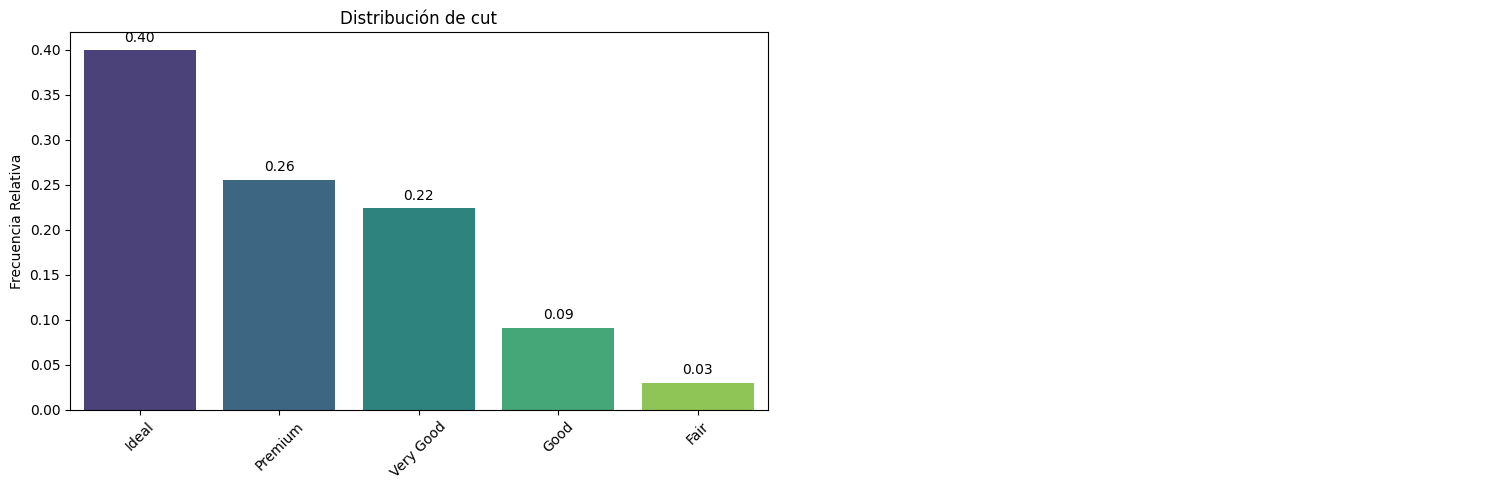

In [4]:
bt.pinta_distribucion_categoricas(df,[target_clasificacion], mostrar_valores= True, relativa= True)

Está desbalanceado pero no vamos a implementar técnicas especiales porque para la ilustración del análisis nos sirve así.

#### Split de datos y tratamiento de features

In [5]:
train_set, test_set = train_test_split(df, test_size= 0.2, random_state= 42)

Tratamos las variables categóricas de clasificación

In [6]:
features_cat_clf = ["color","clarity"] 

En este caso también hay que convertir el target, lo vamos a hacer usando el método `map` de pandas para que tengas otra forma de hacerlo (podríamos haber usado el ordinal enconder de `sklearn`):

In [7]:
mapeo_cut = {
    "Fair": 1,
    "Good": 2,
    "Very Good": 3,
    "Premium": 4,
    "Ideal": 5
}
train_set[target_clasificacion] = train_set[target_clasificacion].map(mapeo_cut)
test_set[target_clasificacion] = test_set[target_clasificacion].map(mapeo_cut)

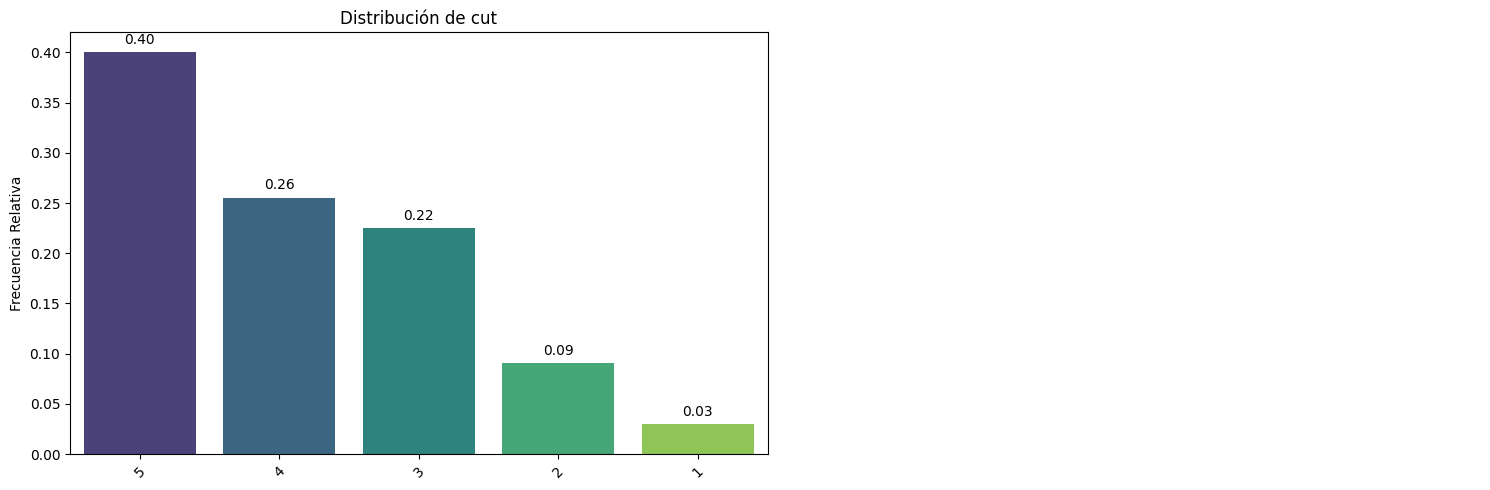

In [8]:
bt.pinta_distribucion_categoricas(train_set, [target_clasificacion], mostrar_valores= True, relativa= True)

Y ahora hacemos el onehot encoding empleando el get_dummies (quizá "clarity" estaría mejor con un codificado ordinal pero, por no complicar la sesión, lo dejamos así)

In [9]:
train_set = pd.get_dummies(train_set, columns= features_cat_clf, dtype = int)
test_set = pd.get_dummies(test_set, columns= features_cat_clf, dtype = int)

Tratamos las variables numéricas para  clasificación

In [10]:
features_num_clf = [col for col in train_set.columns if col not in features_cat_clf and col != target_clasificacion]

In [11]:
scaler_cat = StandardScaler()
train_set[features_num_clf] = scaler_cat.fit_transform(train_set[features_num_clf])
test_set[features_num_clf] = scaler_cat.transform(test_set[features_num_clf])

#### Modelado y Evaluación

Y ahora ya podemos instanciar y entrenar nuestro modelo y ver qué tal es su comportamiento:

In [12]:
X_train_clf = train_set.drop(target_clasificacion, axis = 1)
y_train_clf = train_set[target_clasificacion]
X_test_clf = test_set.drop(target_clasificacion, axis = 1)
y_test_clf = test_set[target_clasificacion]

In [13]:
lr_clf = LogisticRegression(max_iter = 1000)
lr_clf.fit(X_train_clf, y_train_clf)
y_pred_clf = lr_clf.predict(X_test_clf)
print(classification_report(y_test_clf, y_pred_clf))


              precision    recall  f1-score   support

           1       0.73      0.50      0.60       335
           2       0.59      0.13      0.22      1004
           3       0.50      0.43      0.46      2382
           4       0.66      0.72      0.69      2775
           5       0.72      0.87      0.79      4292

    accuracy                           0.66     10788
   macro avg       0.64      0.53      0.55     10788
weighted avg       0.64      0.66      0.63     10788



### Analisis de Errores

Como podíamos suponer el modelo falla en algunas de las clases más que otras, y en las menos representadas especialmente, aunque sorpresa no en la menor.

En general, lo primero es conocer junto con Negocio qué es lo importante a clasificar, cuál las clases más importantes, sus fallos, su precision, su recall y en función de eso establecer un orden de análisis de clase más importante a clase menos importante:


 Veamos la "dirección" de esos fallos en el caso del recall (suponiendo que esto fuera lo importante):

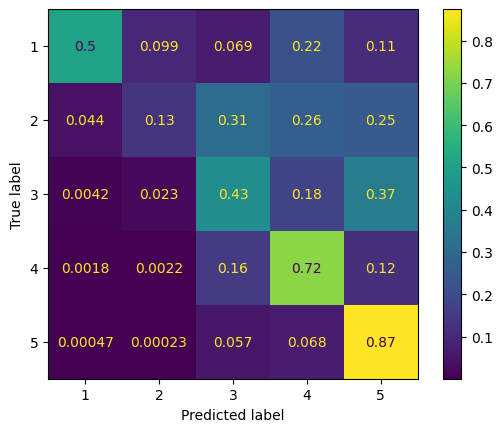

In [14]:
ConfusionMatrixDisplay.from_predictions(y_test_clf, y_pred_clf, normalize= "true") # normalize a true muestra el recall

En este caso hay que leerlo por filas (estamos viendo el recall y las true están por filas):

1. La clase 1 se confunde con la 4 y la 5, esto puede ser importante porque recuerda que aquí las clases están ordenadas. ¿Cómo se trata? Depende del problema, quizás con un modelo adicional que intente mejora la diferencia solo entre estas tres clases. Lo que sí podemos es alertar de este sesgo.
2. La clase 2 no sólo no se clasifica bien (sólo se capta un 13%) sino que sus errores se distribuyen siempre al alza, mejores cortes. Otro sesgo a tener en cuenta o bien hacer un modelo solo para distinguir clase 2 frente al resto (balanceándolo). Luego se ensamblaría con el generíco y si el generico dice clase 2, se le pasa por este otro modelo para asegurarnos.
3. El problema con la clase 3 además de su recall (un 43% puede ser bajo) es que se equivoca sensiblemente más con la clase 5.
4. Las clases 4 y sobre todo 5 están bien de recall (o eso podríamos suponer) y se confunden con una clase anterior. 

De nuevo el tema aquí es valor con negocio el impacto de estos fallos (¿es más impactante clasificar como ideal un fair o un premium como un very good?) y hacer cambios para mejorar en el sentido de reducirlos.

Te dejo como ejercicio mirar la matriz desde el lado de las columnas, es decir la precisión (cuando digo que algo es de la clase x, es de la clase x)


#### Sugerencias para Mejoras

Basado en el análisis, podemos considerar las siguientes mejoras genéricas:
1. **Ingeniería de características**: Añadir, eliminar o transformar características.
2. **Ajuste de hiperparámetros**: Utiliza técnicas como la búsqueda en cuadrícula (grid search) para optimizar los hiperparámetros.
3. **Modelos más complejos o diferentes**: Prueba con diferentes algoritmos de clasificación que puedan capturar mejor las complejidades de tus datos. Ten en cuenta la opción de ensamblar tú a mano modelos que permitan un doble check sobre las clases difíciles en las que sus errores impacten en el negocio de manera más significativa.
4. **Balanceo de clases**: Si tu conjunto de datos está desequilibrado, considera técnicas como sobremuestreo (oversampling) o submuestreo (undersampling).



### Errores en Regresiones

#### Preparación de datos

Hagamos algunas modificaciones sencillas para convertir el problema de clasificación en uno de regresión. Basta con cambiar el target, que ahora será el precio del diamante, y cambiar el juego de features predictoras:

<Axes: xlabel='price', ylabel='Count'>

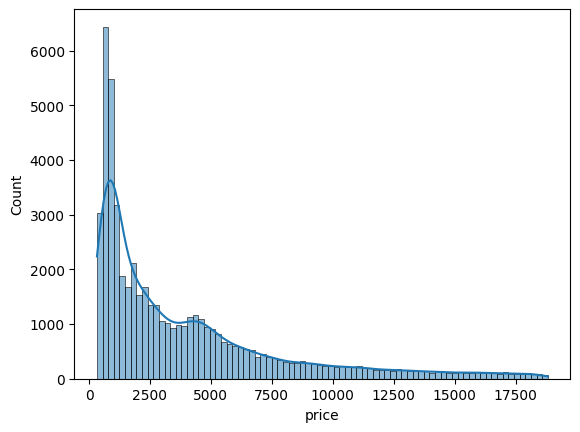

In [15]:
sns.histplot(x= "price", data = df, kde = True)

In [16]:
target_regresion = "price"
features_cat_reg = features_cat_clf + [target_clasificacion]
features_num_reg = features_num_clf.copy()
features_num_reg.remove("price")

# Invertimos el escalado del precio
train_set["price"] = scaler_cat.inverse_transform(train_set[features_num_clf])[:,features_num_clf.index("price")]
test_set["price"] = scaler_cat.inverse_transform(test_set[features_num_clf])[:,features_num_clf.index("price")]

<Axes: xlabel='price', ylabel='Count'>

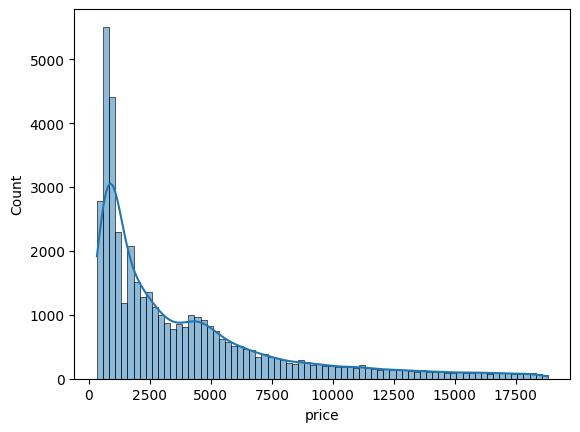

In [17]:
sns.histplot(x= "price", data = train_set, kde = True)

#### Modelado y Evaluación


Creamos los juegos X,y ahora que hemos cambiado el target y las features:

In [18]:
X_train_reg = train_set.drop(target_regresion, axis = 1)
y_train_reg = train_set[target_regresion]
X_test_reg = test_set.drop(target_regresion, axis = 1)
y_test_reg = test_set[target_regresion]

In [19]:
rf_reg = RandomForestRegressor(max_depth = 5, random_state= 42)
rf_reg.fit(X_train_reg, y_train_reg)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",5
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples a

Evaluamos:

In [20]:
y_pred_reg = rf_reg.predict(X_test_reg)
print("MAE:", mean_absolute_error(y_test_reg, y_pred_reg))
print("MAPE:", mean_absolute_percentage_error(y_test_reg, y_pred_reg))
print("RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred_reg)))

MAE: 633.2100993622522
MAPE: 0.1737651732177281
RMSE: 1157.572247097316


#### Análisis de Errores

En el caso de las regresiones no disponemos de una matriz de confusión pero sí de los errores individuales como una variable continua a la que se le pueden analizar propiedades y hacer un par de visualizaciones:

**$y_{real}$ vs. $y_{predicha}$**

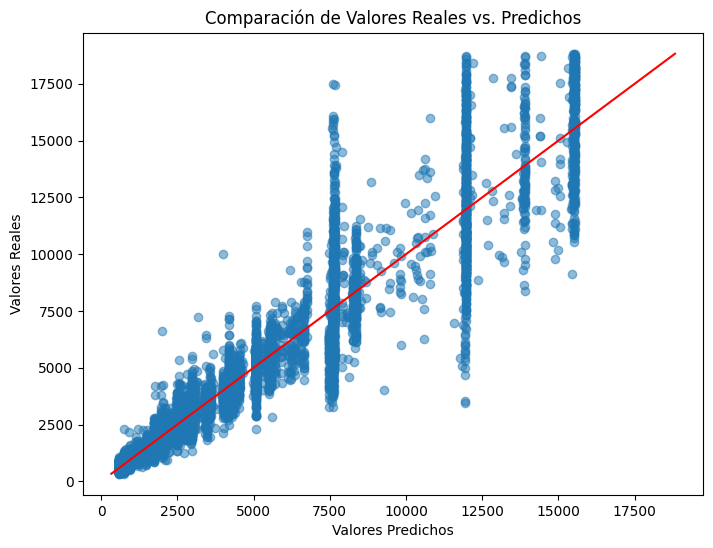

In [21]:
plot_predictions_vs_actual(y_test_reg, y_pred_reg)

Podemos observar que el modelo tiene un comportamiento regular a precios "bajo" y a partir de los 7500 la dispersión de errores es más grande y por franjas.

¿Cómo podemos tratarlo? Pues a posteriori o haciendo un modelo sólo para precios superiores a 7500 y pasándolo por segunda vez a nuestra predicción o bien avisando a Negocio y buscando soluciones... Lo que sí es que tenemos esa información de cómo de bueno y malo es nuestro modelo actual (sin optimizar hiperparámetros)

**Residuos**

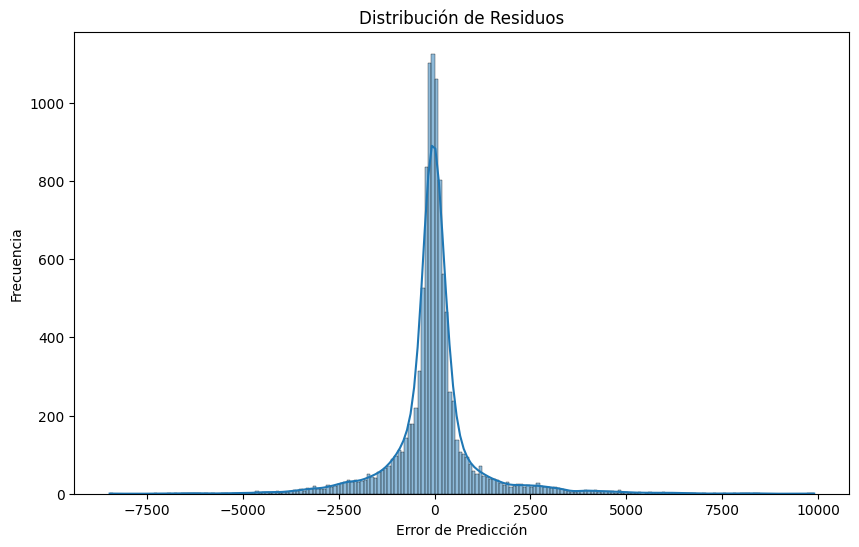

In [22]:
# Calcular residuos
residuos = y_test_reg - y_pred_reg

# Visualización de residuos
plt.figure(figsize=(10, 6))
sns.histplot(residuos, kde=True)
plt.title('Distribución de Residuos')
plt.xlabel('Error de Predicción')
plt.ylabel('Frecuencia')
plt.show()


Son errores distribuidos normalmente, y eso suele ser "bueno" para las regresiones, pero es importante completar el análisis viendo la gráfica inicial de otra manera.

Podemos terminar de ver la dispersión de los residuos, si existen patrones el modelo está sesgando y deberíamos tratarlo.

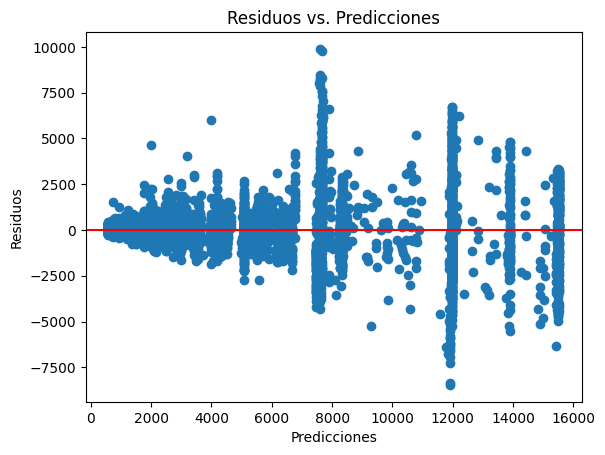

In [23]:
# Gráfica de dispersión de residuos
plt.scatter(y_pred_reg, residuos)
plt.title('Residuos vs. Predicciones')
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()


Claramente deberíamos pensar en qué hacer con esos puntos en los que la predicción se concentra pero los valores reales son muy dispersos. Fíjate que los problemas comienzan más o menos cuando comienza la cola de la distribución de precios. En este caso el análisis de errores nos sugiere o hacer dos modelos uno para precios bajos y otros para altos, o bien binnear el precio y convertirla en un problema de clasificación.



#### Sugerencias para Mejoras

En función del análisis, tenemos más o menos las mismas posibilidades genéricas que en clasificación con el añadido de tratar los outliers (y las largas colas, como en el ejemplo que hemos visto) de forma particular:

1. **Ingeniería de características**: Añadir, eliminar o transformar características.
2. **Ajuste de hiperparámetros**: Optimizar los hiperparámetros del modelo.
3. **Modelos más complejos o diferentes**: Probar diferentes algoritmos de regresión.
4. **Análisis de Outliers**: Investigar y manejar adecuadamente los valores atípicos en los datos y las distribuciones particulares como las heavy tail. 
